#### **Importing Libraries**

In [1]:
# Common imports 
import numpy as np
from pprint import pprint  

# to make this notebook's output stable across runs
np.random.seed(42) 

# sklearn specific imports 
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.pipeline import make_pipeline ,Pipeline
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model  import SGDClassifier, RidgeClassifier, LogisticRegression ,LogisticRegressionCV
from sklearn.model_selection import cross_validate, RandomizedSearchCV,GridSearchCV, cross_val_predict ,learning_curve

from sklearn.neighbors import KNeighborsClassifier

# log loss is also known as cross entropy loss
from sklearn.metrics import log_loss 
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score, recall_score, classification_report 
from sklearn.metrics import precision_recall_curve ,make_scorer ,f1_score
from sklearn.metrics import roc_curve, roc_auc_score 

#scipy 
from scipy.stats import loguniform 

# To plot pretty figures 
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.colors
import matplotlib.pyplot as plt 
import seaborn as sns;sns.set()

# global settings 
mpl.rc('axes',labelsize=14) 
mpl.rc('xtick',labelsize=12) 
mpl.rc('ytick',labelsize=12) 
mpl.rc('figure',figsize=(8,6))

import warnings 
warnings.filterwarnings('ignore')

## **Handwritten Digit Classification**

### **Dataset** 

Each datapoint is contained in $x_i$ ∊  $\mathbb{R}^{784}$ and the label $y_i$ ∊ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## **Binary Classification**

### **Changing labels to binary**

Let us do binary classification with KNN classifier and eventually extend it to Multiclass setup.

In [4]:
# initialize new variable names with all -1
y_train_0 = -1*np.ones(len(y_train))
y_test_0 = -1*np.ones(len(y_test))

# find indices of digit 0 image
indx_0 = np.where(y_train == '0')

# remember original labels are of type str not int, so use those indices to modify y_train_0 & y_test_0

y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

### **Data Visualization in Lower Dimensions**

* Let us apply PCA on the datapoints and reduce the dimensions to 2D and then to 3D.

* This will give us some rough idea about the points in $ \mathbb {R}^{784}$

* One interesting thing to look at is the change in the magnitude of the data points before and after applying PCA.

In [5]:
from sklearn.decomposition import PCA

pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
X_train_pca_2d = pipe_pca_2d.fit_transform(X_train)

**Visualization of the 2D data obtained through PCA**

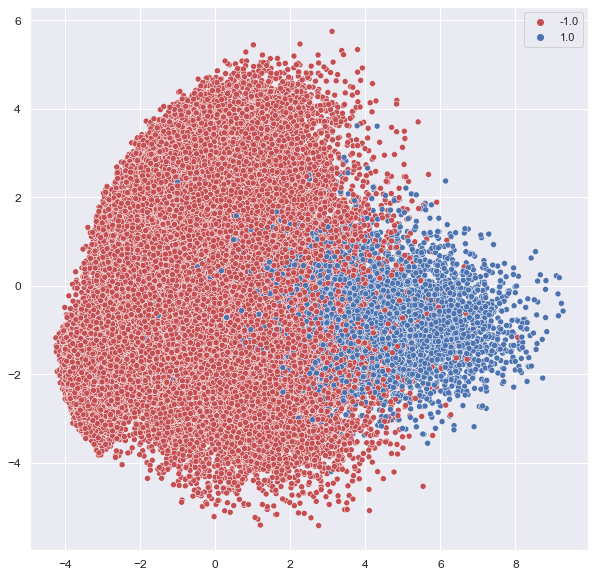

In [6]:
plt.figure(figsize=(10, 10))
cmap = matplotlib.colors.ListedColormap(['r', 'b'])
sns.scatterplot(x=X_train_pca_2d[:, 0], y=X_train_pca_2d[:, 1],
                data=X_train_pca_2d, hue=y_train_0, palette=cmap)
plt.show()

**Projection in 3D using PCA**

In [7]:
pipe_pca_3d = make_pipeline(MinMaxScaler() ,PCA(n_components=3))
X_train_pca_3d = pipe_pca_3d.fit_transform(X_train)

In [8]:
import plotly.express as px 

cmap = matplotlib.colors.ListedColormap(['r', 'b'])

fig = px.scatter_3d(x=X_train_pca_3d[:,0],
                    y=X_train_pca_3d[:,1],
                    z=X_train_pca_3d[:,2],
                    color=y_train_0, 
                    color_discrete_map=cmap,
                    opacity=0.5)

fig.show()

## **KNN classifier**

#### **Algorithm :**

1. Set $k$ to desired value i.e. how many neighbors should be allowed to participate in prediction. 

2. Calculate the distance between the new example and every example from the data. Thus, creating a distance vector. 

3. Get indices of nearest $k$ neighbors. 

4. Get the labels of the selected $k$ entries. 

5. If it is a classification task, return the majority class by computing mode of $k$ labels.

To understand the working of sklearn built-in function, we first create a KNN classifier model with $k$=3 and consider a smaller number of samples of training and test set. 

* The `KNeighborsClassifer` creates a classifier instance. 

* There are many optional arguments such as `n_neighbors, metric, weights,` .... that can be set to suitable values while creating an instance.

Creating a new pipeline for classifier : 

We use the variables `pipe_pca_2d` for preprocessing the samples alone and `pipe_clf_pca_2d` for classification.

In [9]:
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d, KNeighborsClassifier(n_neighbors=3))

Let us train the model with 10 samples from training set (i.e. we are just putting 10 datapoints in the metric space, not building any parameterized model)

Then test the model with 10 datapoints from  test set.

In [10]:
index_neg = np.argsort(y_train_0)[:5]
index_pos = np.argsort(y_train_0)[-1:-6:-1]

# create a small dataset
x = np.vstack((X_train[index_pos, :], X_train[index_neg, :]))
y = np.hstack((y_train_0[index_pos], y_train_0[index_neg]))

In [11]:
y

array([ 1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.])

In [12]:
pipe_clf_pca_2d.fit(x,y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [13]:
# for visulization
x_reduced = pipe_clf_pca_2d[0].transform(x)

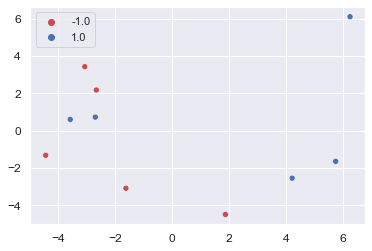

In [14]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1],
                hue=y, marker='o', palette=['r', 'b'])
plt.grid(True)
plt.show()

In [15]:
y_hat_0 = pipe_clf_pca_2d.predict(X_test[:10,:])

print('Test label : ',y_test_0[:10])
print('Predicted Label : ',y_hat_0[:10])

Test label :  [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
Predicted Label :  [ 1. -1.  1.  1. -1.  1. -1. -1.  1.  1.]


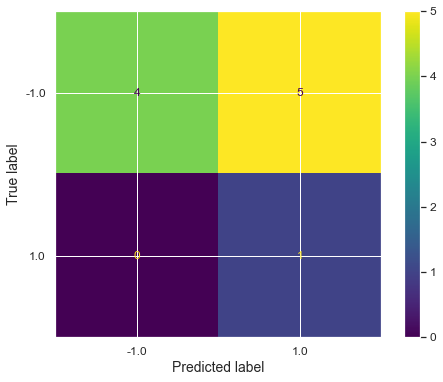

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test_0[:10],y_hat_0)
plt.show()

**Observe that** : 

* We can see that there are more FP's (as 9 out 10 actual labels are negative)

* Let us display both the training points and testing points with their predictions. 

* We can visually validate the reason behind the performance.

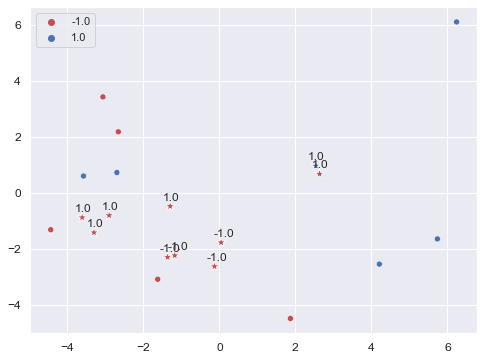

In [17]:
cmap = matplotlib.colors.ListedColormap(['r', 'b'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1],
                marker='o', hue=y, palette=cmap)

x_test_reduced = pipe_clf_pca_2d[0].transform(X_test[:10, :])
sns.scatterplot(x=x_test_reduced[:, 0], y=x_test_reduced[:, 1],
                s=100, marker='*', hue=y_test_0[:10], palette=cmap, legend=None)

dx, dy = -0.2, 0.2
for i in range(10):
    plt.annotate(str(y_hat_0[i]), xy=(x_test_reduced[i, 0]+dx, x_test_reduced[i, 1]+dy))

plt.grid(True)
plt.show()

* It would be much better if we know the distance of 3 neighbors for each testing points. 

* Let us display the distance and connnectivity of neighbors to the test datapoints using th class `NearestNeighbors`. 

* In fact, `KNeighborsClassifier` calls `NearestNeighbors` class internally to compute all these distances.

In [18]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=3)
neighbors.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

which are the first three closest neighbors to the first three in the test set. And how close are they? 

In [19]:
dist_neighbors, idx_neighbors = neighbors.kneighbors(pipe_pca_2d.transform(X_test[:10]), 3, return_distance=True)

In [20]:
import statistics

for i in range(3):
    print('Distance : {0} \nIndex : {1} \nLabels : {2} \nPrediction : {3}'.format(dist_neighbors[i],idx_neighbors[i],y[idx_neighbors[i].flatten()],
    statistics.mode(y[idx_neighbors[i].flatten()])))

    print('-'*20)


Distance : [1.54510433 1.56004731 1.61914472] 
Index : [1 4 6] 
Labels : [ 1.  1. -1.] 
Prediction : 1.0
--------------------
Distance : [0.95703587 3.33077652 3.39001596] 
Index : [7 1 6] 
Labels : [-1.  1. -1.] 
Prediction : -1.0
--------------------
Distance : [1.14297879 2.0379748  2.22709669] 
Index : [6 4 1] 
Labels : [-1.  1.  1.] 
Prediction : 1.0
--------------------


Let us train the model with 10000 samples from training set (i.e. we are just putting 10000 datapoints in the metric space, not building any parameterized model).

In [21]:
pipe_clf_pca_2d.fit(X_train[:10000],y_train_0[:10000]) 

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

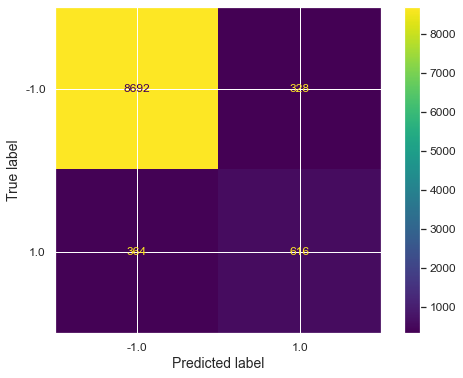

In [22]:
y_hat_0 = pipe_clf_pca_2d.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show()

In [23]:
print(classification_report(y_test_0,y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000



* Let's vary the n_neighbours from **k=1 to 19** and study the performance of the model.

* We use the first 10000 samples from training set.

In [24]:
precision=[] 

for k in range(1,20,2):
    pipe_clf_pca_2d.__n_neighbors=k 
    pipe_clf_pca_2d.fit(X_train[:10000],y_train_0[:10000]) 
    
    y_hat_0 = pipe_clf_pca_2d.predict(X_test) 
    precision.append(precision_score(y_test_0,y_hat_0))

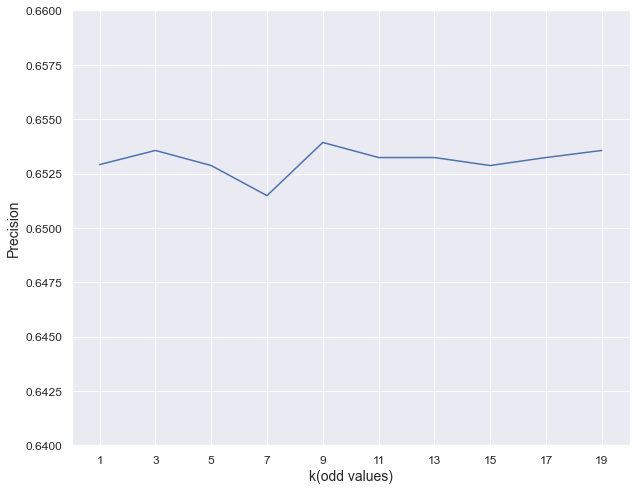

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 20, 2), precision)

plt.xlim((0, 20))
plt.ylim((0.64, 0.66))
plt.xlabel('k(odd values)')
plt.ylabel('Precision')

plt.xticks(ticks=np.arange(1, 20, 2), labels=np.arange(1, 20, 2))
plt.grid(True)
plt.show()

### **Going without PCA** 

* Let us use KNN classifier with **all the features** in the training samples with the hope that it **increases the performance** of the model (of course at the cost of computation) 

* Let's search for $k$ by using cross validation. 

* **NOTE :** It takes about 4 minutes for entire computation.

In [26]:
pipe_knn = make_pipeline(MinMaxScaler(),
                         KNeighborsClassifier(n_neighbors=1))

In [27]:
grid_k = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11]}

cv = GridSearchCV(pipe_knn, param_grid=grid_k, scoring='precision', cv=5,n_jobs=1)

In [28]:
cv.fit(X_train, y_train_0)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             n_jobs=1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11]},
             scoring='precision')

In [29]:
pprint(cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             n_jobs=1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11]},
             scoring='precision')


In [30]:
pprint(cv.cv_results_)

{'mean_fit_time': array([0.47387152, 0.47961373, 0.48359861, 0.47079964, 0.48920078,
       0.50660219]),
 'mean_score_time': array([6.87688494, 6.80422387, 6.82959933, 6.78840113, 6.78140354,
       6.97860017]),
 'mean_test_score': array([0.97805545, 0.98229094, 0.98212333, 0.98245498, 0.98111657,
       0.98078408]),
 'param_kneighborsclassifier__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'kneighborsclassifier__n_neighbors': 1},
            {'kneighborsclassifier__n_neighbors': 3},
            {'kneighborsclassifier__n_neighbors': 5},
            {'kneighborsclassifier__n_neighbors': 7},
            {'kneighborsclassifier__n_neighbors': 9},
            {'kneighborsclassifier__n_neighbors': 11}],
 'rank_test_score': array([6, 2, 3, 1, 4, 5]),
 'split0_test_score': array([0.97920133, 0.98493724, 0.98166667, 0.98086522, 0.97921862,
       0.97921862]),


**The best value obtained for k is 7.** (check in test_rank_score)

In [31]:
pipe_knn = make_pipeline(MinMaxScaler(),KNeighborsClassifier(n_neighbors=7))
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

#### **Checking performance on test set**

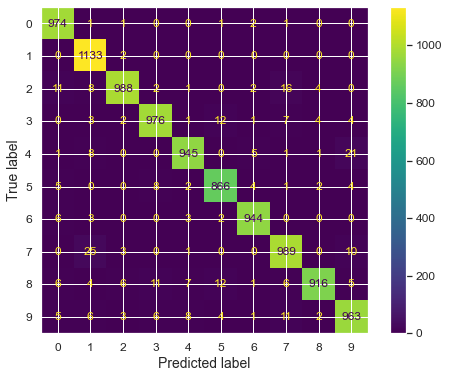

In [33]:
y_hat_0 = pipe_knn.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_0)
plt.show()

## **Multiclass Classification**

Extending KNN classifier to mulitclass classification is pretty simple straightforward.

In [34]:
pprint(pipe_knn)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])


In [39]:
pipe_knn.fit(X_train, y_train)
y_hat = pipe_knn.predict(X_test)

In [40]:
pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [41]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

